In [1]:
import numpy as np
from sklearn.cluster import KMeans

In [2]:
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in xrange(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [34]:
from create_matrix import *

region = "Austin"
year = 2014
from create_matrix import *
df, dfc = create_matrix_single_region('Austin', 2014)

In [35]:
df_agg = df[['aggregate_1', 'aggregate_2','aggregate_3','aggregate_4','aggregate_5','aggregate_6','aggregate_7','aggregate_8','aggregate_9','aggregate_10','aggregate_11','aggregate_12']]
matrix = df_agg.values

In [85]:
labels, centroids, X_hat = kmeans_missing(matrix, 3, 100)

In [86]:
pd.value_counts(labels)

1    213
0    158
2    104
dtype: int64

In [87]:
labels = np.array(labels)

In [88]:
%matplotlib inline

In [89]:
from plot_functions import *
import matplotlib.pyplot as plt

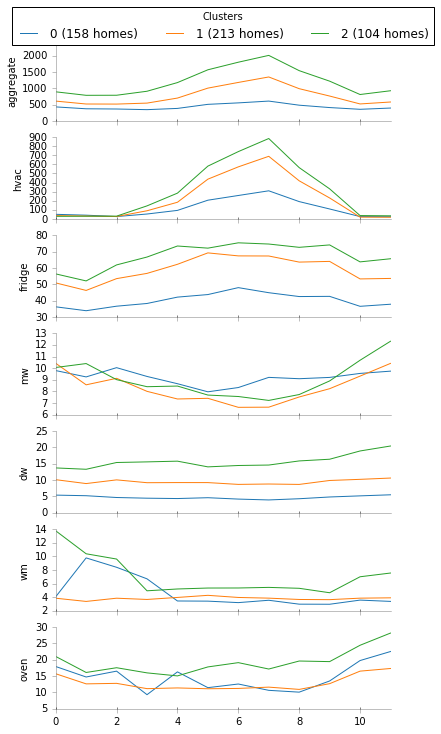

In [90]:
fig, ax = plt.subplots(nrows=7, figsize=(6, 12), sharex=True)
for i, appliance in enumerate(APPLIANCES_ORDER):
    for k in range(3):
        a = df[["%s_%d" %(appliance, month) for month in range(1, 13)]].ix[df_agg.index[labels==k]]
        a.columns = range(12)
        a.mean().plot(color=tableau20blind[::2][k], label=k, ax=ax[i], linewidth=1)
       
        #plt.legend(title="Clusters")
        format_axes(ax[i])
        ax[i].set_ylabel(appliance)
    #plt.xlabel("Month")
    #plt.ylabel("Aggregate energy")
#plt.figlegend()
#
L = ax[0].legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', borderaxespad=0., ncol=3, title="Clusters")
for k in range(3):
    L.get_texts()[k].set_text(str(k)+" ("+str(pd.value_counts(labels)[k])+" homes)")
  

Now, let us check which cluster the error prone homes belong to for each appliance.

In [130]:
import pickle
tensor_all_p = pickle.load(open("predictions/filtered_o_tf_all_appliances_static_weather.pkl",'r'))['filtered_tf_all_appliances_static_weather']
best_a = {'aggregate': '9',
 'dw': '6',
 'fridge': '2',
 'hvac': '9',
 'mw': '5',
 'oven': '5',
 'wm': '9'}

In [131]:
predictions = {appliance: tensor_all_p[appliance]['None']['None'][best_a[appliance]]  for appliance in best_a}

In [156]:
import os
st = pd.HDFStore(os.path.expanduser("~/all.h5"), mode='r')

### HVAC

In [242]:
from cycler import cycler

def find_an(home, appliance, month, agg=False):
    plt.rc('axes', prop_cycle=(cycler('color', tableau20blind[::2])))
    for clus in range(3):
        if home in df_agg.index[labels==clus]:
            closest_clus = clus
            break
    closest_cluster_mean = df[["%s_%d" %(appliance, month) for month in range(1, 13)]].ix[df_agg.index[labels==closest_clus]].mean()
    closest_cluster_mean.index= range(1, 13)
    closest_cluster_mean.plot(label="Closest cluster mean %s" %appliance)
    gt_appliance = df.ix[home][["%s_%d" %(appliance, month) for month in range(1, 13)]]
    gt_appliance.index = range(1, 13)
    gt_appliance.plot(label="GT %s" %appliance)
    pred_appliance = predictions[appliance].ix[home]
    pred_appliance.index = range(1, 13)

    pred_appliance.plot(label="Predicted %s" %appliance)
    plt.axvline(an_month, color='grey', linewidth=20, alpha=0.2)
    if agg:
        closest_cluster_mean_agg = df[["%s_%d" %("aggregate", month) for month in range(1, 13)]].ix[df_agg.index[labels==closest_clus]].mean()
        closest_cluster_mean_agg.index= range(1, 13)
        closest_cluster_mean_agg.plot(label="Closest cluster mean aggregate")
        
        gt_agg = df.ix[home][["%s_%d" %("aggregate", month) for month in range(1, 13)]]
        gt_agg.index = range(1, 13)
        gt_agg.plot(label="GT aggregate")
        
        pred_agg = predictions["aggregate"].ix[home]
        pred_agg.index = range(1, 13)
        pred_agg.plot(label="Pred aggregate")
        
    
    format_axes(plt.gca())
    plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
    
    plt.xlabel("Month")
    plt.ylabel("Energy")
    plt.title(home)

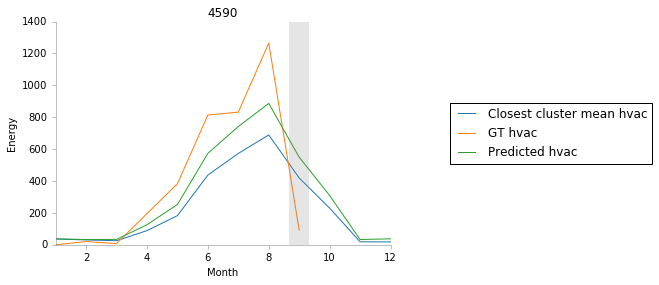

In [305]:
home = 4590
appliance="hvac"
an_month = 9
find_an(home, appliance, month)

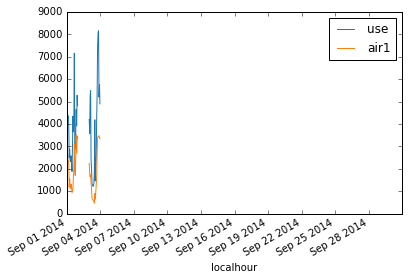

In [306]:
st['/%d' %home]['2014-9'][['use','air1']].plot()

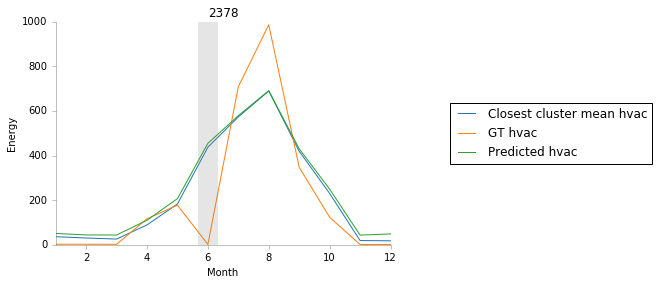

In [307]:
home = 2378
appliance="hvac"
an_month = 6
find_an(home, appliance, month)

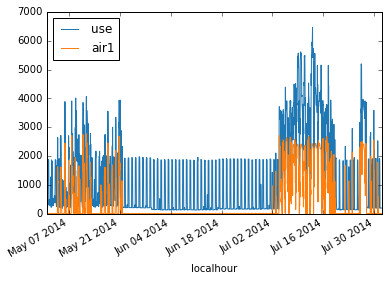

In [308]:
st['/%d' %home]['2014-5':'2014-7'][['use','air1']].plot()

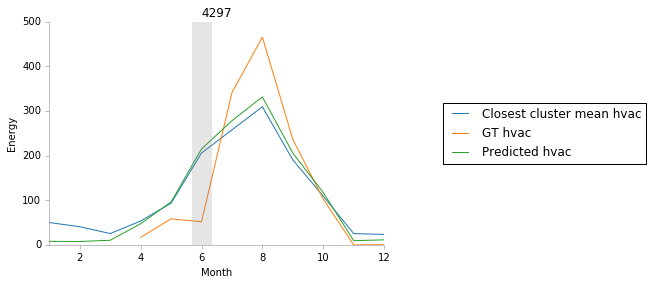

In [309]:
home = 4297
appliance="hvac"
an_month = 6
find_an(home, appliance, month)

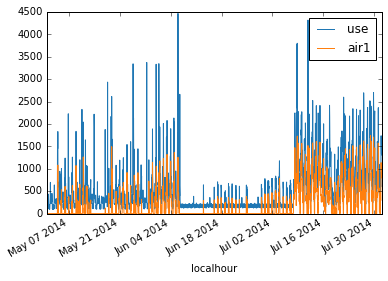

In [310]:
st['/%d' %home]['2014-5':'2014-7'][['use','air1']].plot()

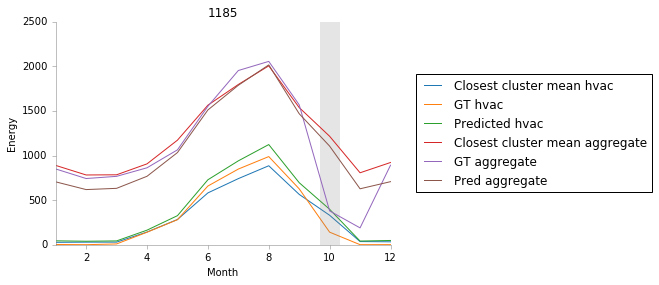

In [311]:
home = 1185
appliance="hvac"
an_month = 10
find_an(home, appliance, month, True)

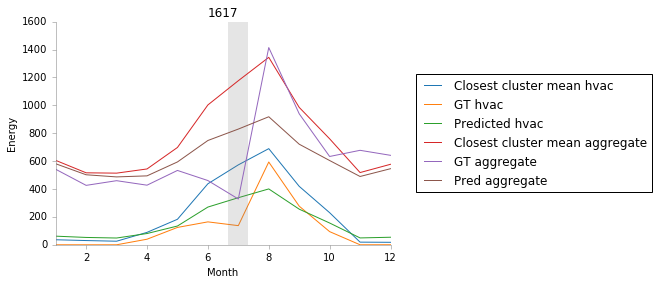

In [312]:
home = 1617
appliance="hvac"
an_month = 7
find_an(home, appliance, month, True)

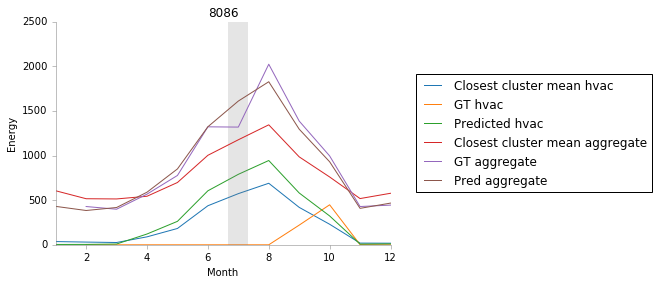

In [313]:
home = 8086
appliance="hvac"
an_month = 7
find_an(home, appliance, month, True)

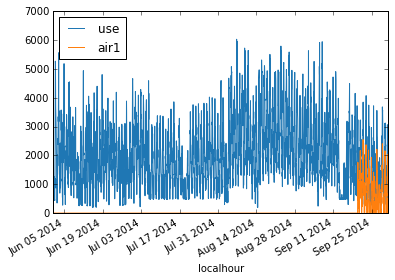

In [314]:
st['/%d' %home]['2014-6':'2014-9'][['use','air1']].plot()

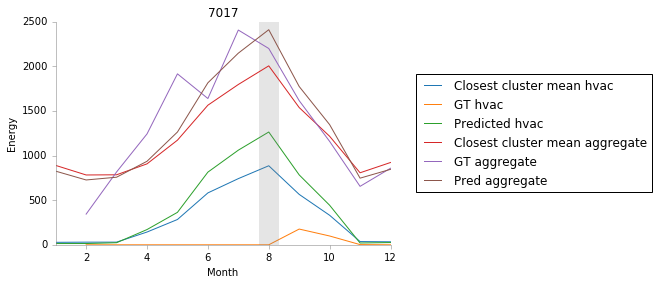

In [315]:
home = 7017
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

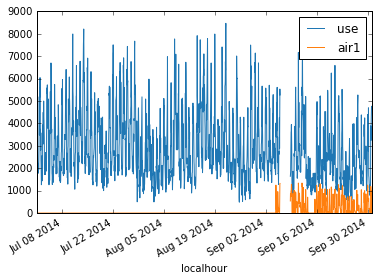

In [316]:
st['/%d' %home]['2014-7':'2014-9'][['use','air1']].plot()

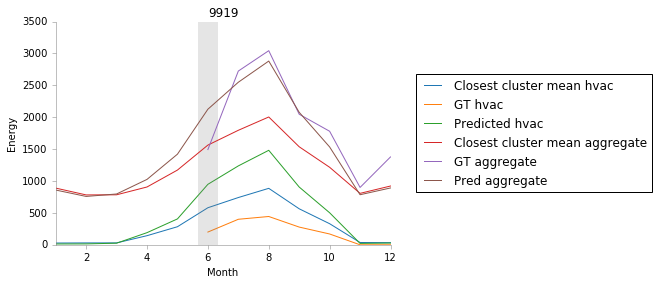

In [317]:
home = 9919
appliance="hvac"
an_month = 6
find_an(home, appliance, month, True)

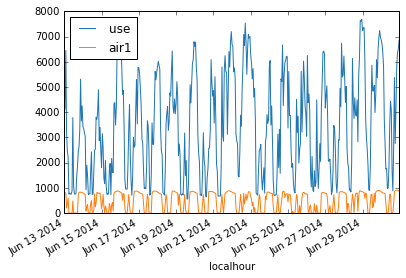

In [318]:
st['/%d' %home]['2014-4':'2014-6'][['use','air1']].plot()

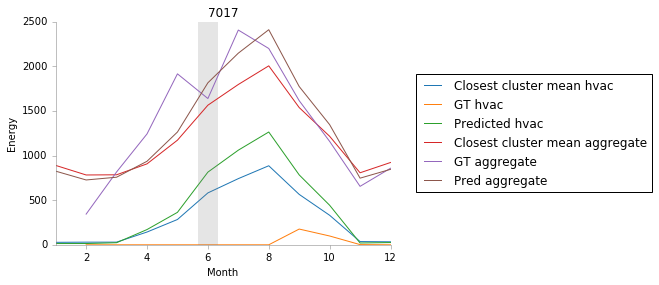

In [319]:
home = 7017
appliance="hvac"
an_month = 6
find_an(home, appliance, month, True)

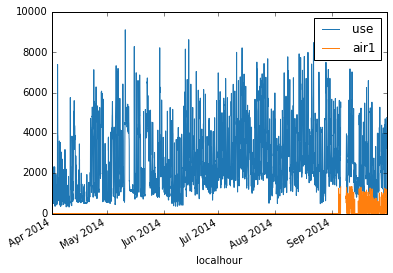

In [320]:
st['/%d' %home]['2014-4':'2014-9'][['use','air1']].plot()

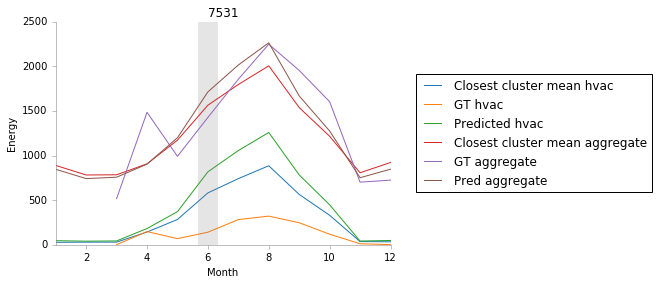

In [321]:
home = 7531
appliance="hvac"
an_month = 6
find_an(home, appliance, month, True)

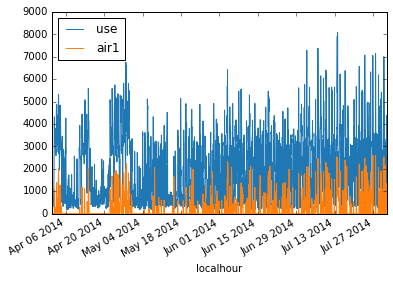

In [322]:
st['/%d' %home]['2014-4':'2014-7'][['use','air1']].plot()

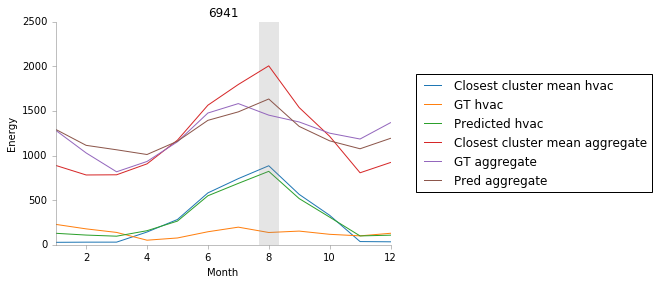

In [323]:
home = 6941
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

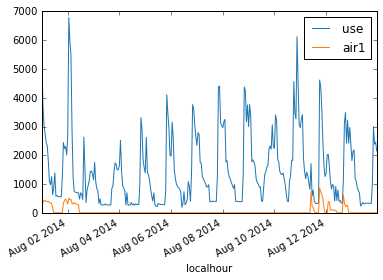

In [324]:
st['/%d' %home]['2014-8':'2014-8-13'][['use','air1']].plot()

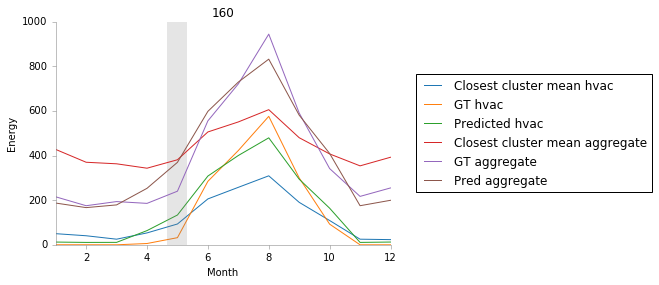

In [325]:
home = 160
appliance="hvac"
an_month = 5
find_an(home, appliance, month, True)

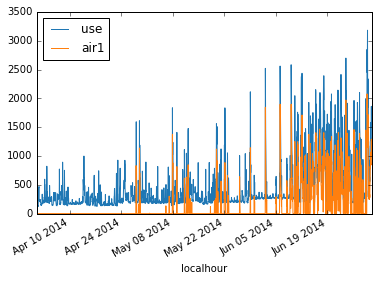

In [326]:
st['/%d' %home]['2014-4':'2014-6'][['use','air1']].plot()

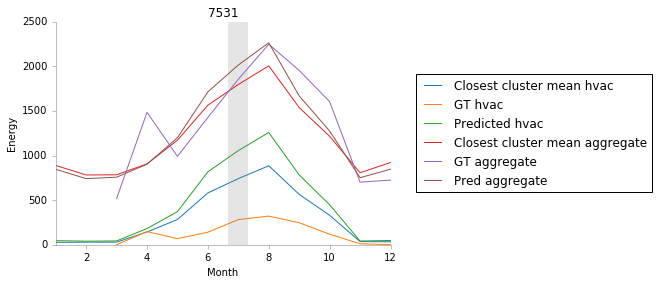

In [327]:
home = 7531
appliance="hvac"
an_month = 7
find_an(home, appliance, month, True)

### RMSE on raw energy readings

In [329]:
best_a = {'aggregate': {},
 'dw': '6',
 'fridge': '3',
 'hvac': '10',
 'mw': '2',
 'oven': '5',
 'wm': '9'}

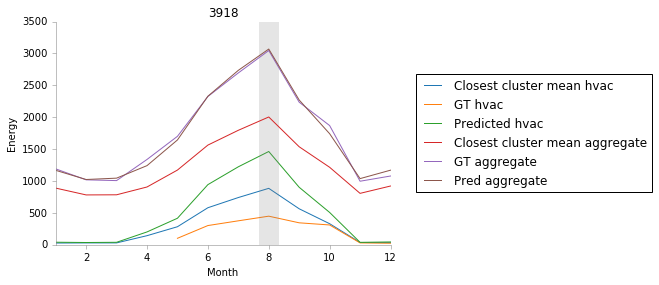

In [330]:
home = 3918
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

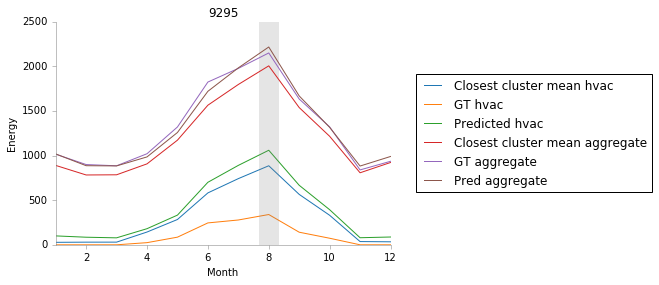

In [331]:
home = 9295
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

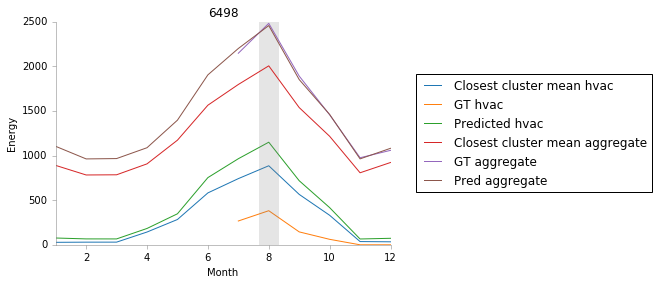

In [332]:
home = 6498
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

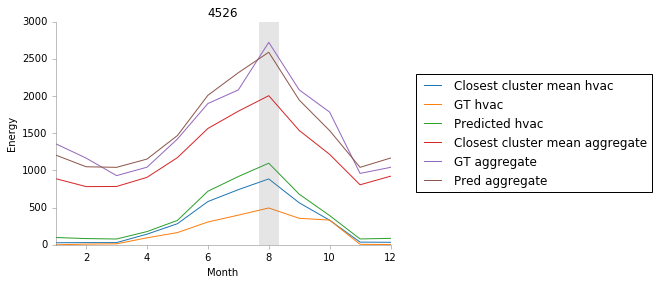

In [333]:
home = 4526
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

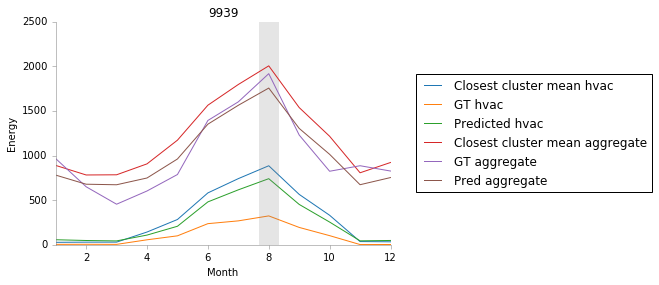

In [334]:
home = 9939
appliance="hvac"
an_month = 8
find_an(home, appliance, month, True)

## Fridge

### RMSE fraction

In [335]:
best_a = {'aggregate': '9',
 'dw': '6',
 'fridge': '2',
 'hvac': '9',
 'mw': '5',
 'oven': '5',
 'wm': '9'}

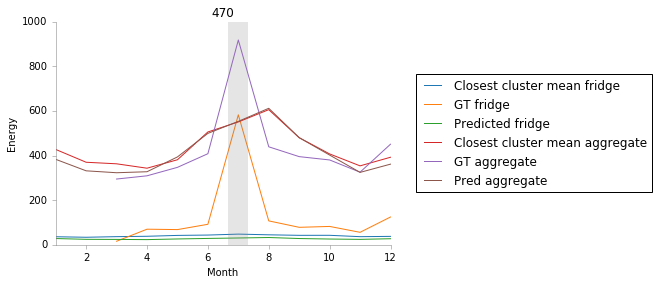

In [336]:
home = 470
appliance="fridge"
an_month = 7
find_an(home, appliance, month, True)

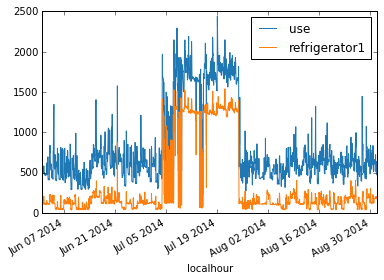

In [337]:
st['/%d' %home]['2014-6':'2014-8'][['use','refrigerator1']].plot()

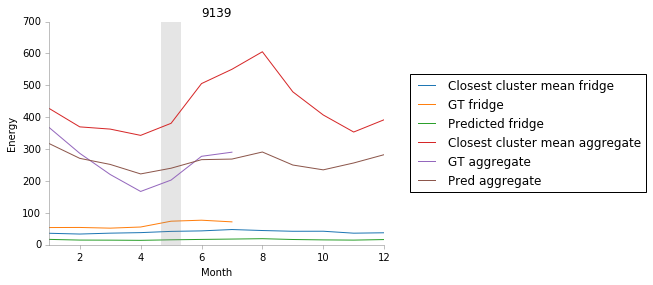

In [338]:
home = 9139
appliance="fridge"
an_month = 5
find_an(home, appliance, month, True)

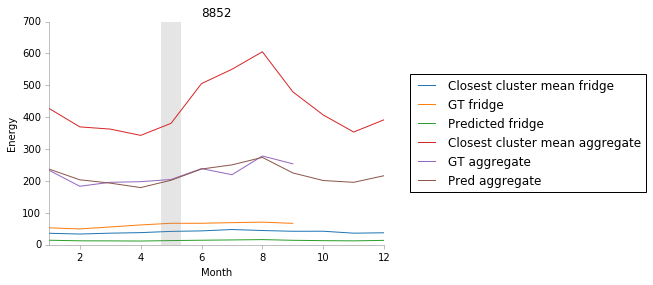

In [339]:
home = 8852
appliance="fridge"
an_month = 5
find_an(home, appliance, month, True)

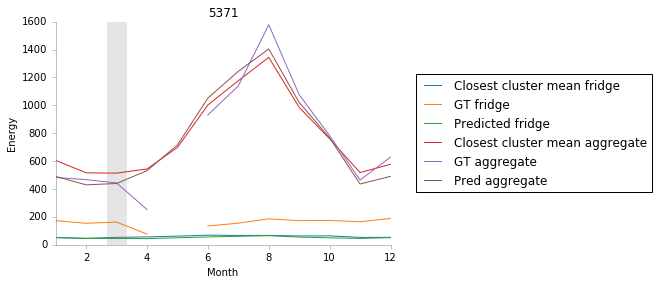

In [340]:
home = 5371
appliance="fridge"
an_month = 3
find_an(home, appliance, month, True)

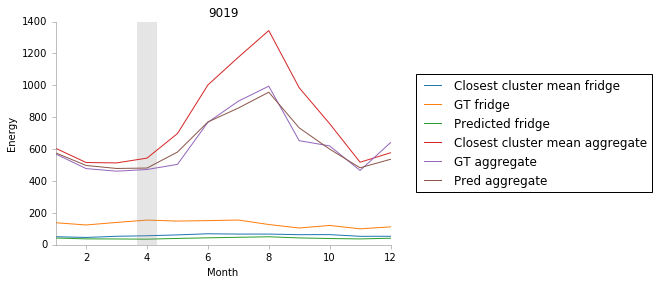

In [341]:
home = 9019
appliance="fridge"
an_month = 4
find_an(home, appliance, month, True)

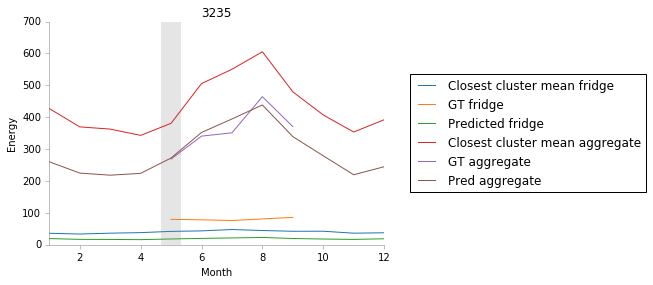

In [342]:
home = 3235
appliance="fridge"
an_month = 5
find_an(home, appliance, month, True)

### RMSE raw

In [343]:
best_a = {'aggregate': {},
 'dw': '6',
 'fridge': '3',
 'hvac': '10',
 'mw': '2',
 'oven': '5',
 'wm': '9'}

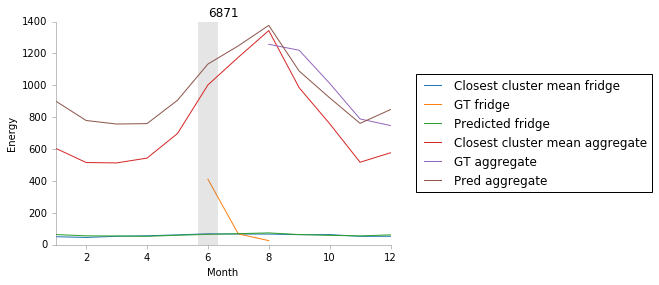

In [344]:
home = 6871
appliance="fridge"
an_month = 6
find_an(home, appliance, month, True)

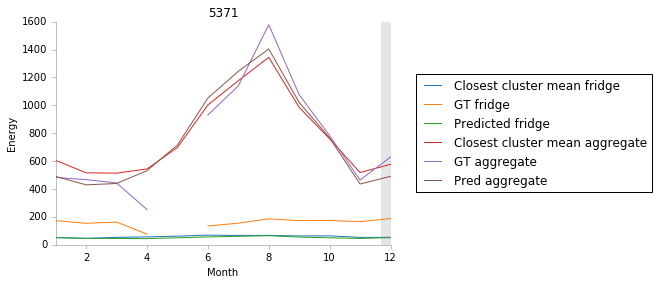

In [345]:
home = 5371
appliance="fridge"
an_month = 12
find_an(home, appliance, month, True)

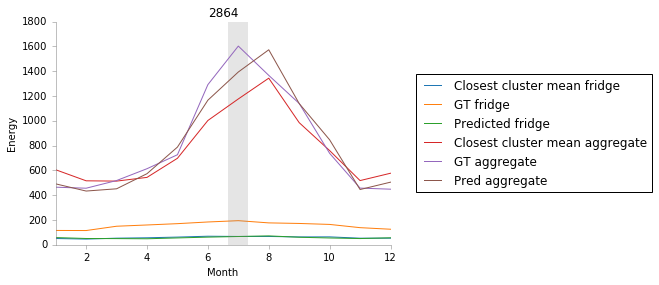

In [346]:
home = 2864
appliance="fridge"
an_month = 7
find_an(home, appliance, month, True)

## Dishwasher

### RMSE fraction

In [304]:
best_a={'aggregate': '9',
 'dw': '6',
 'fridge': '2',
 'hvac': '9',
 'mw': '5',
 'oven': '5',
 'wm': '9'}

{'aggregate': '9',
 'dw': '6',
 'fridge': '2',
 'hvac': '9',
 'mw': '5',
 'oven': '5',
 'wm': '9'}

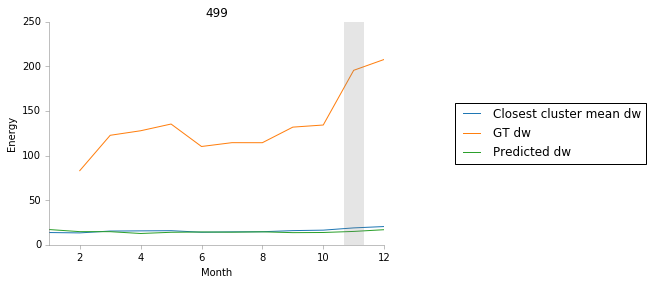

In [349]:
home = 499
appliance="dw"
an_month = 11
find_an(home, appliance, month)

In [358]:
appliance="dw"
df[['%s_%d' %(appliance, month) for month in range(1, 13)]].mean()

dw_1      9.346734
dw_2      8.595285
dw_3      8.984025
dw_4      8.493031
dw_5      8.535857
dw_6      8.394708
dw_7      8.116483
dw_8      8.146555
dw_9      8.550530
dw_10     9.341115
dw_11    10.198024
dw_12    10.777801
dtype: float64

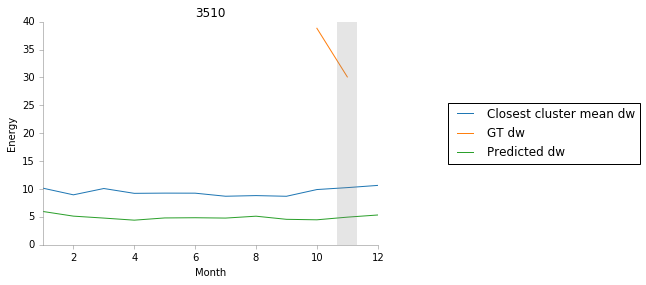

In [359]:
home = 3510
appliance="dw"
an_month = 11
find_an(home, appliance, month)

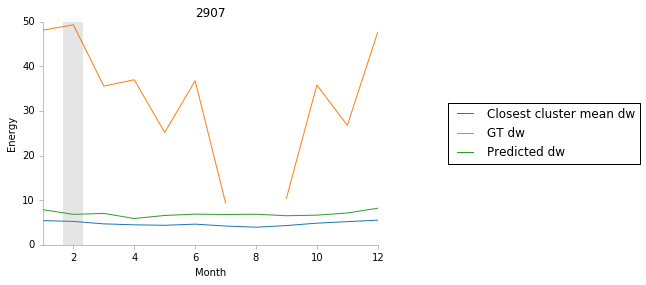

In [361]:
home = 2907
appliance="dw"
an_month = 2
find_an(home, appliance, month)

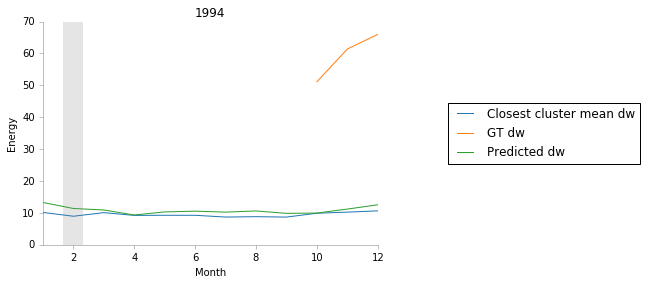

In [362]:
home = 1994
appliance="dw"
an_month = 2
find_an(home, appliance, month)

### Washing machine

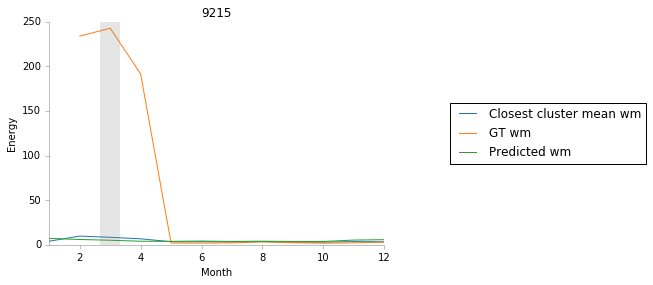

In [364]:
home = 9215
appliance="wm"
an_month = 3
find_an(home, appliance, month)

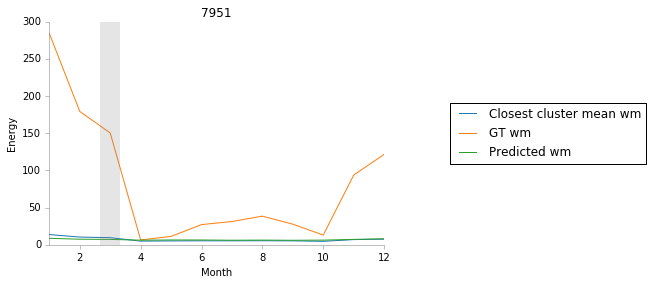

In [365]:
home = 7951
appliance="wm"
an_month = 3
find_an(home, appliance, month)

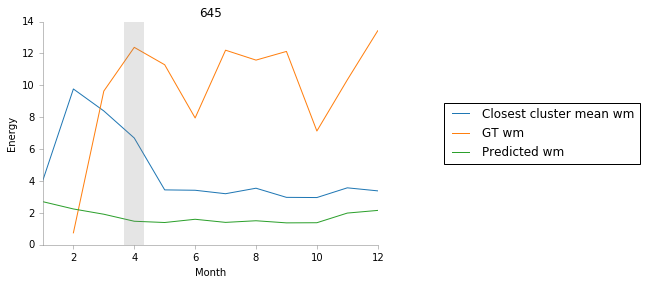

In [369]:
home = 645
appliance="wm"
an_month = 4
find_an(home, appliance, month)

In [366]:
appliance="wm"
df[['%s_%d' %(appliance, month) for month in range(1, 13)]].mean()

wm_1     6.805596
wm_2     7.030680
wm_3     6.895322
wm_4     5.103296
wm_5     4.082750
wm_6     4.262141
wm_7     4.076139
wm_8     4.170517
wm_9     3.858540
wm_10    3.678694
wm_11    4.514904
wm_12    4.611399
dtype: float64

### MW

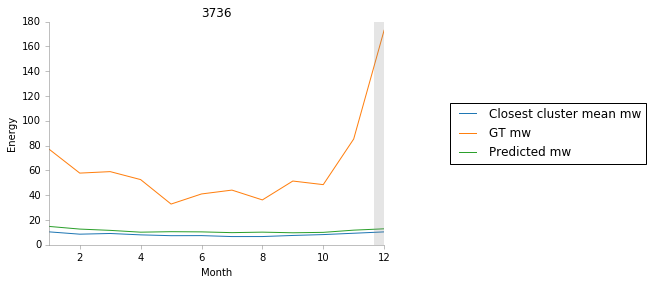

In [370]:
home = 3736
appliance="mw"
an_month = 12
find_an(home, appliance, month)

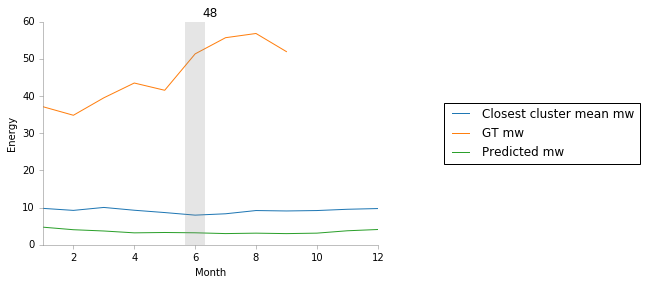

In [373]:
home = 48
appliance="mw"
an_month = 6
find_an(home, appliance, month)

In [371]:
appliance="mw"
df[['%s_%d' %(appliance, month) for month in range(1, 13)]].mean()

mw_1     10.171054
mw_2      9.214685
mw_3      9.444750
mw_4      8.601408
mw_5      8.126523
mw_6      7.690021
mw_7      7.483033
mw_8      7.702771
mw_9      8.113537
mw_10     8.706859
mw_11     9.696522
mw_12    10.605448
dtype: float64

In [ ]:
1589    
4590    
117    
         7641   
hvac_6   2378    105.129679
hvac_8   5109    100.493877
hvac_5   9578     92.817485
hvac_8   4927     91.220640
hvac_6   8600     84.008100
         4297     80.033007
hvac_9   668      78.500284
hvac_5   8386     74.117800
         2361     74.062438
hvac_10  1185     73.381323
hvac_7   8086     62.699437
hvac_8   7017     61.976739
hvac_6   9931     57.469826
         9919     57.120013
hvac_8   7638     54.696920
         1479     54.182755

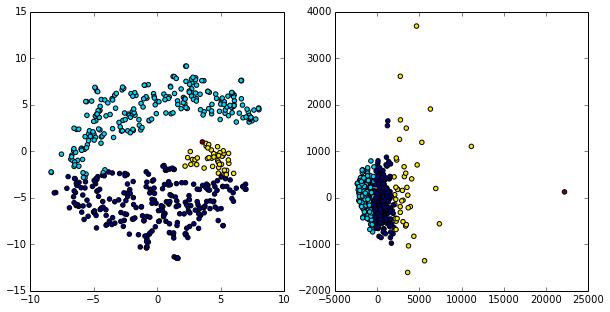

In [74]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=labels)